In [ ]:
import pandas as pd
from datetime import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import shap
import optuna
import warnings

In [37]:
#Load data
path = r"C:\Users\maxwell.bicking\membership_data_syn.csv"


df = pd.read_csv(path)

"""
We will filter exclusively for contacts that are associated with membership. 
This will ensure our analysis is truly related to membership, and gets rid of 
unecessary noise.

"""

df = df[df['ASSOCIATED_WITH_MEMBERSHIP'] == 1]

In [5]:
df.head()

,Unnamed: 0,COUNTRY,AGE,EMAIL_OPT_OUT,CALL_OPT_OUT,DAYS_SINCE_CREATED,DAYS_SINCE_MODIFIED,DAYS_SINCE_LAST_ACTIVITY,HOME_CALL_OPT_OUT,MOBILE_CALL_OPT_OUT,...,DAYS_SINCE_LAST_DONATION,TOTAL_DONATION_AMOUNT,TOTAL_DONATIONS,TOTAL_DONATION_AMOUNT_LY,TOTAL_DONATIONS_LY,ASSOCIATED_WITH_MEMBERSHIP,TITLE_CHANGE,PUSHED,CHURNED,ZIP_CODE
0,0,United States,44.0,True,False,2225,641,712.0,False,False,...,NaN,0.00,1,3.53,1,1,0,0,0,19106
1,1,United States,70.0,True,False,2402,149,787.0,False,False,...,NaN,0.40,4,0.02,0,1,0,1,0,10106
2,2,United States,21.0,True,False,1425,23,NaN,False,False,...,NaN,0.08,2,0.02,0,1,1,0,0,19106
3,3,United States,66.0,True,False,2410,232,194.0,False,False,...,NaN,0.05,3,1406.15,2,1,1,1,0,19106
4,4,United States,40.0,True,False,2412,140,NaN,False,False,...,NaN,159.67,8,69.58,1,1,0,1,0,NaN


In [7]:
df.columns

Index(['Unnamed: 0', 'COUNTRY', 'AGE', 'EMAIL_OPT_OUT', 'CALL_OPT_OUT',
       'DAYS_SINCE_CREATED', 'DAYS_SINCE_MODIFIED', 'DAYS_SINCE_LAST_ACTIVITY',
       'HOME_CALL_OPT_OUT', 'MOBILE_CALL_OPT_OUT', 'OTHER_CALL_OPT_OUT',
       'PERSONAL_EMAIL_OPT_OUT', 'WORK_CALL_OPT_OUT', 'WORK_EMAIL_OPT_OUT',
       'DECEASED', 'GENDER', 'INCOME_LEVEL', 'DAYS_SINCE_JOINED',
       'INSTITUTION_TYPE', 'MEMBER_TYPE', 'MEMBERSHIP_STATUS',
       'PRIMARY_RESEARCH_AREA', 'RACE', 'DO_NOT_EMAIL', 'PRE_POST_DOC',
       'HIGHEST_DEGREE', 'NET_WORTH', 'SMALL_BUSINESS_OWNER',
       'IMPORTED_CAR_OWNER', 'MULTI_PROPERTY_OWNER', 'NONPROFIT_BOARD_MEMBER',
       'RECENT_MORTGAGE', 'POLITICAL_DONOR', 'RECENT_DIVORCE', 'RECENT_MOVER',
       'TOP_POLITICAL_DONOR', 'LUXURY_CAR_OWNER', 'TRUST',
       'PHILANTHROPIC_GIVER', 'PLANE_OWNER', 'BOAT_OWNER', 'POLITICAL_PARTY',
       'DAYS_SINCE_LAST_EVENT', 'TOTAL_MEETING_PAID_AMOUNT',
       'TOTAL_NUMBER_OF_EVENTS_ATTENDED', 'TOTAL_MEETING_PAID_AMOUNT_LY',
      

In [56]:
# Identify boolean columns 
bool_cols = df.select_dtypes(include='bool').columns

# Convert them to 0/1
df[bool_cols] = df[bool_cols].astype(int)

add actual eda here, show calculation of totals and nulls etc

In [47]:
# Filter out warnings originating from the xgboost training module
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost.training")
warnings.filterwarnings('ignore', category=FutureWarning)

In [57]:
#--- Identify Numeric and Categorical Columns ---
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['Unnamed: 0', 'AGE', 'EMAIL_OPT_OUT', 'CALL_OPT_OUT', 'DAYS_SINCE_CREATED', 'DAYS_SINCE_MODIFIED', 'DAYS_SINCE_LAST_ACTIVITY', 'HOME_CALL_OPT_OUT', 'MOBILE_CALL_OPT_OUT', 'OTHER_CALL_OPT_OUT', 'PERSONAL_EMAIL_OPT_OUT', 'WORK_CALL_OPT_OUT', 'WORK_EMAIL_OPT_OUT', 'DECEASED', 'DAYS_SINCE_JOINED', 'MEMBER_TYPE', 'MEMBERSHIP_STATUS', 'DO_NOT_EMAIL', 'PRE_POST_DOC', 'NET_WORTH', 'SMALL_BUSINESS_OWNER', 'IMPORTED_CAR_OWNER', 'MULTI_PROPERTY_OWNER', 'NONPROFIT_BOARD_MEMBER', 'RECENT_MORTGAGE', 'POLITICAL_DONOR', 'RECENT_DIVORCE', 'RECENT_MOVER', 'TOP_POLITICAL_DONOR', 'LUXURY_CAR_OWNER', 'TRUST', 'PHILANTHROPIC_GIVER', 'PLANE_OWNER', 'BOAT_OWNER', 'DAYS_SINCE_LAST_EVENT', 'TOTAL_MEETING_PAID_AMOUNT', 'TOTAL_NUMBER_OF_EVENTS_ATTENDED', 'TOTAL_MEETING_PAID_AMOUNT_LY', 'TOTAL_EVENTS_LY', 'LAST_DONATION_AMOUNT', 'DAYS_SINCE_LAST_DONATION', 'TOTAL_DONATION_AMOUNT', 'TOTAL_DONATIONS', 'TOTAL_DONATION_AMOUNT_LY', 'TOTAL_DONATIONS_LY', 'ASSOCIATED_WITH_MEMBERSHIP', 'TITLE_CHANGE', '

#### <p style="text-align: center;"> Pushed </p> 

Improved with Hyperparameter Tuning

In [ ]:
# ----------------------- Data Preparation ----------------------- #
# We drop the target columns 'CHURNED' and 'PUSHED' from the features.
X = df.drop(columns=['CHURNED', 'PUSHED'])
# Define the target variable for the PUSHED prediction.
y = df['PUSHED']

# ----------------------- Handling Categorical Variables ----------------------- #
# Convert categorical features into numeric codes.
# XGBoost requires numerical inputs, so here we encode any column of type 'object'.
for col in X.select_dtypes(include='object'):
    X[col] = X[col].astype('category').cat.codes

# ----------------------- Train-Test Split ----------------------- #
# Split the dataset into training and testing sets.
# Stratification is used here to maintain the same class ratio in both sets, which is important for imbalanced classes.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------- Calculate Class Weight ----------------------- #
# Compute the scale_pos_weight for imbalanced classes.
# This parameter helps XGBoost to weigh the minority class heavier during training.
scale_pos_weight_push = (y_train == 0).sum() / (y_train == 1).sum()

# ----------------------- Hyperparameter Tuning with Optuna ----------------------- #
# Define the objective function that Optuna will optimize.
def objective_push(trial):
    # Define the hyperparameter search space for XGBoost.
    params = {
        "tree_method": "hist",       # Use histogram-based algorithm for speed.
        "use_label_encoder": False,   # Avoids using an internal label encoder.
        "eval_metric": "logloss",     # Evaluation metric set to logloss.
        "scale_pos_weight": scale_pos_weight_push,  # Helping with class imbalance.
        "n_jobs": -1,                 # Use all available cores.
        "random_state": 42,           # For reproducibility.
        # Hyperparameters to tune:
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_uniform("gamma", 0, 10)
    }
    
    # Initialize the XGBoost classifier with the chosen parameters.
    model = xgb.XGBClassifier(**params)
    # Define a 5-fold StratifiedKFold for cross-validation (maintains the class ratio).
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Evaluate the model using cross-validation with ROC-AUC as the metric.
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")
    return scores.mean()

# Create an Optuna study to maximize the ROC-AUC score.
study_push = optuna.create_study(direction="maximize")
# Run the optimization with 50 trials (adjust as needed for exploration/exploitation balance).
study_push.optimize(objective_push, n_trials=50)

# Print out the best hyperparameters and the best CV ROC-AUC score.
print("Best parameters for PUSHED:", study_push.best_params)
print("Best CV ROC-AUC for PUSHED:", study_push.best_value)

[I 2025-04-15 19:02:34,845] A new study created in memory with name: no-name-c30ebefb-f758-4b1e-a23f-37a0f346a26f
C:\Users\maxwell.bicking\AppData\Local\Temp\ipykernel_14452\3427384072.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\maxwell.bicking\AppData\Local\Temp\ipykernel_14452\3427384072.py:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
C:\Users\maxwell.bicking\AppData\Local\Temp\ipykernel_14452\3427384072.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/o

Best parameters for PUSHED: {'max_depth': 3, 'learning_rate': 0.08198674780219062, 'n_estimators': 274, 'subsample': 0.7675974027412551, 'colsample_bytree': 0.9976751757659695, 'min_child_weight': 6, 'gamma': 2.296710055857462}
Best CV ROC-AUC for PUSHED: 0.7272933239099203


Continued

In [ ]:
# ----------------------- Final Model Training and Evaluation ----------------------- #
#Update the best parameters with constants that remain fixed.
best_params_push = study_push.best_params.copy()
best_params_push.update({
    "tree_method": "hist",
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "scale_pos_weight": scale_pos_weight_push,
    "n_jobs": -1,
    "random_state": 42
})

#Initialize the final XGBoost classifier using the best found parameters.
model_push = xgb.XGBClassifier(**best_params_push)
#Train the final model on the complete training data.
model_push.fit(X_train, y_train)

# ----------------------- Model Evaluation on Test Set ----------------------- #
#Generate predictions for the test set.
y_pred_push = model_push.predict(X_test)
#Also get prediction probabilities to compute the ROC-AUC.
y_prob_push = model_push.predict_proba(X_test)[:, 1]

#Calculate accuracy and ROC-AUC metrics.
accuracy_push = accuracy_score(y_test, y_pred_push)
roc_auc_push = roc_auc_score(y_test, y_prob_push)

print("Test Accuracy for PUSHED:", accuracy_push)
print("Test ROC-AUC for PUSHED:", roc_auc_push)


c:\Users\maxwell.bicking\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:10:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy for PUSHED: 0.6621474209131993
Test ROC-AUC for PUSHED: 0.7244010109517742


Evaluation

=== PUSHED Model Evaluation ===
Accuracy: 0.6621474209131993
ROC-AUC: 0.7244010109517742

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68     13695
           1       0.63      0.66      0.64     11973

    accuracy                           0.66     25668
   macro avg       0.66      0.66      0.66     25668
weighted avg       0.66      0.66      0.66     25668

Confusion Matrix:
[[9124 4571]
 [4101 7872]]


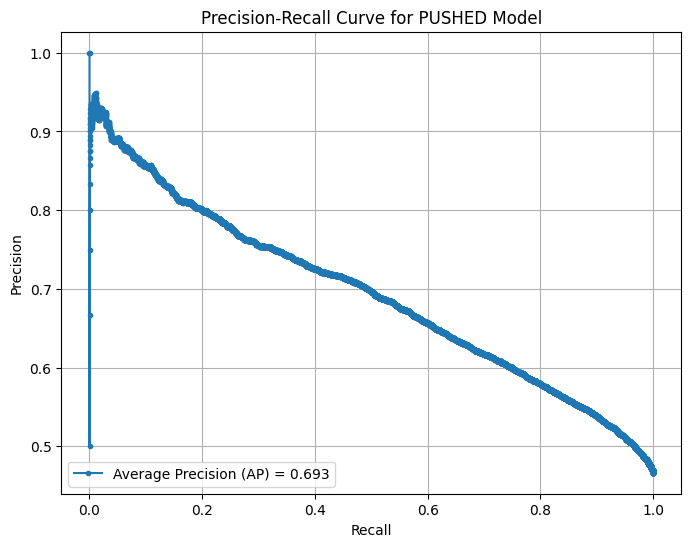

In [42]:
# --- Assumptions ---
# The final PUSHED model (model_push) has been trained using the previous script.
# X_test and y_test refer to your hold-out test data for the PUSHED classification task.

# --- Step 1: Generate Predictions ---
# Predict binary labels for the test set.
y_pred_push = model_push.predict(X_test)
# Predict probabilities for the positive class (needed for PR curve).
y_prob_push = model_push.predict_proba(X_test)[:, 1]

# --- Step 2: Compute Basic Evaluation Metrics ---
# Calculate accuracy and ROC-AUC.
accuracy_push = accuracy_score(y_test, y_pred_push)
roc_auc_push = roc_auc_score(y_test, y_prob_push)

print("=== PUSHED Model Evaluation ===")
print("Accuracy:", accuracy_push)
print("ROC-AUC:", roc_auc_push)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_push))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_push))

# --- Step 3: Generate the Precision-Recall Curve ---
# Compute precision, recall, and thresholds.
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob_push)
# Compute the average precision score as a summary metric.
avg_precision = average_precision_score(y_test, y_prob_push)

# --- Step 4: Plot the Precision-Recall Curve ---
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', 
         label=f'Average Precision (AP) = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for PUSHED Model')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


Feature Importance

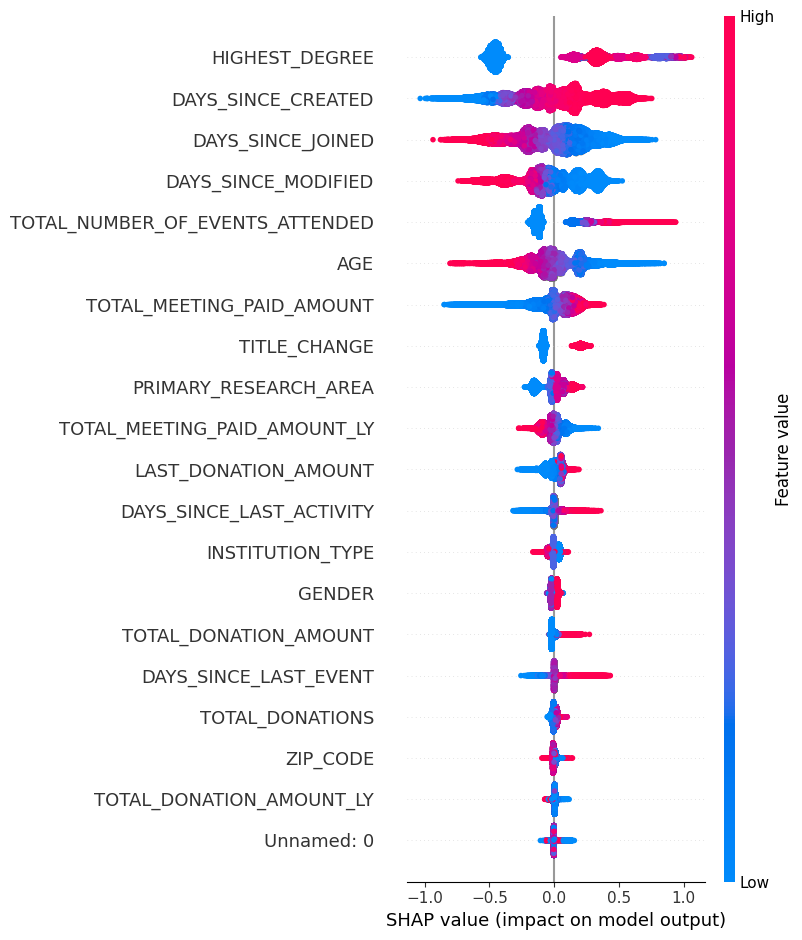

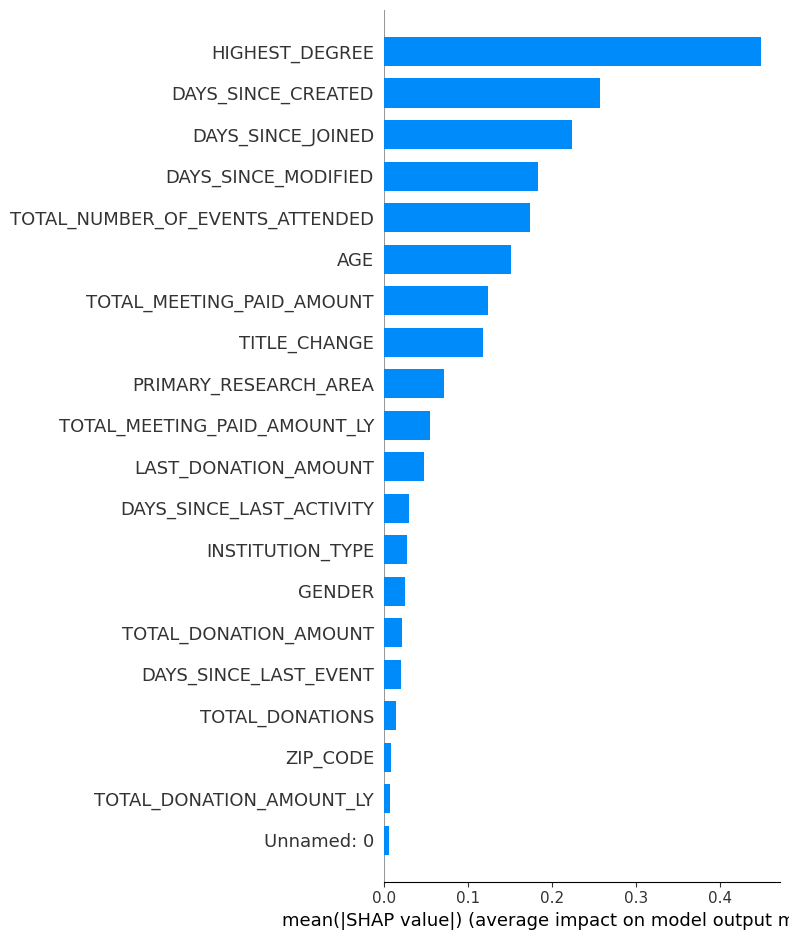

In [43]:
# --- Assumptions ---
# The final model for PUSHED is stored in 'model_push'
# and X_train (or X_test) is available with the features used during training.

# Create a SHAP TreeExplainer for the PUSHED model
explainer_push = shap.TreeExplainer(model_push)

# Compute SHAP values on the training set (you can also use X_test)
shap_values_push = explainer_push.shap_values(X_train)

# --- Generate a Beeswarm Plot ---
# This plot shows the impact of each feature across samples.
shap.summary_plot(shap_values_push, X_train, plot_type="dot", show=True)

# --- Generate a Bar Plot for Mean Absolute SHAP Values ---
plt.figure()
shap.summary_plot(shap_values_push, X_train, plot_type="bar", show=True)